# Assignment 3#

Diya Li

In [ ]:
# python 3.6
!pip install box2d-py
!pip install gym
!pip install gym[Box_2D]

# For rendering environment and video 
!apt-get install python-opengl x11-utils -y
!apt install xvfb -y
!pip install PyOpenGL
!pip install pyvirtualdisplay
!pip install PyOpenGL-accelerate
# for logging and monitoring 
!pip install piglet
!pip install wandb

In [2]:
!nvidia-smi
# checkout GPU

Wed Mar 24 04:04:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Question 1 (20pts)** Implement DQN (with experience replay) using a Neural Network as the Q function approximator on the LunarLander-v2 environment from OpenAI gym. Plot the total reward obtained **per episode**. The problem is solved if the total  reward per episode is **200 or above**. You may have to use a  sliding average window to get clean plots. Link your plot in the code block below. 

In [1]:
import wandb
import tqdm.notebook as tqdm
from matplotlib import animation
import gym
from collections import deque
import matplotlib.pyplot as plt
import os 

In [2]:
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
def show_video(video_path):
    # to show video in notebook
    # test.mp4
    mp4 = video_path
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))

###
# to solve the problem below 
# https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [3]:
# experience memory
import random
from collections import namedtuple
import torch
import numpy as np

# transition and experiences memory impelmetn from pytorch tutorial
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'new_state', 'done'))


def set_seed(seed, env):
    np.random.seed(seed)
    env.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

class ExperiencesReplay:
    """ Class for experience replay """
    def __init__(self, max_length, device):
        self.max_length = max_length
        self.experiences = []
        self.current_index = 0
        self.device = device

    def append(self, item):
        """
        Append an Experience tuple to the buffer.
        If the buffer's length is equal to the maximum length,
        replaces the oldest Experience instead.
        :param item: Experience tuple
        """
        if len(self.experiences) < self.max_length:
            self.experiences.append(item)
        else:
            self.experiences[self.current_index % self.max_length] = item

        self.current_index += 1
    def sample(self, batch_size):
        """
        Samples a batch of uniformly random Experiences.
        :param batch_size: size of the batch to be drawn
        :return: the batch
        """
        batch = Transition(*zip(*random.sample(self.experiences, batch_size)))

        states = torch.stack(batch.state).to(self.device)
        next_states = torch.stack(batch.new_state).to(self.device)
        actions = torch.LongTensor(batch.action).reshape(-1, 1).to(self.device)
        rewards = torch.FloatTensor(batch.reward).reshape(-1, 1).to(self.device)
        dones = torch.FloatTensor(batch.done).reshape(-1, 1).to(self.device)
        return states, next_states, actions, rewards, dones

    def can_sample(self, batch_size):
        """
        Check if the length of the buffer is enough to provide a sample.
        :param batch_size: size of the batch to be drawn
        :return: True if there the number of
            Experiences tuple is greater or equal batch_size
        """
        return len(self.experiences) >= batch_size

In [4]:
# agent
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    # Basic fully-connected neural network. with linear layer
    def __init__(self, input_dim, output_dim, mid_dim):
        # input_dim is state dim
        # out_dim is action dim
        super(DQN, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, mid_dim),
                                 nn.ReLU(),
                                #  nn.Dropout(p=0.6),
                                 nn.Linear(mid_dim, mid_dim), 
                                 nn.ReLU(),
                                #  nn.Dropout(p=0.6),
                                #  nn.Linear(mid_dim, mid_dim), 
                                #  nn.ReLU(inplace=True),
                                #  nn.Dropout(p=0.6),
                                 nn.Linear(mid_dim, output_dim))

    def forward(self, x):
        # Perform a pass through the network.
        # :param x: current state of the environment
        # :return: predicted q-values for each action
        return self.net(x)

    def save(self, filename):
        # Save the network weights to file.
        torch.save(self.state_dict(), filename)

    def load(self, filename, device):
        # Loads the network weights from file.
        self.load_state_dict(torch.load(filename, map_location=device))


import torch.optim as optim
import torch.nn.functional as F
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

class BaseAgent:
    """
    Basic agent abstract class.
    """
    def __init__(self,
                 max_memory_size,
                 batch_size,
                 eps_start,
                 eps_end,
                 decay_rate,
                 device,
                 decay_type="power",
                 learn_freq=4):
        # param learn_freq: how often should the networks weight be updated

        self.model_name = "Base"

        # self.decay_law = self.decay_options(decay_type)
        self.decay_type = decay_type
        self.device = device

        # policy
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.decay_rate = decay_rate
        self.curr_step = 0
        self.curr_eps = eps_start

        # experiences replay
        self.memory = ExperiencesReplay(max_memory_size, device)
        self.batch_size = batch_size

    def set_tensor(self, s):
        return torch.tensor(s, dtype=torch.float, device=self.device)

    def update_eps(self):
        if self.decay_type == 'exp':
            self.curr_eps = max(
                self.eps_end, 
                self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.curr_step * self.decay_rate))
        elif self.decay_type == 'power':
            self.curr_eps = max(
                self.eps_end, 
                self.curr_eps * self.decay_rate)
        elif self.decay_type == 'linear':
            self.curr_eps = max(
                self.eps_end, 
                self.curr_eps - ((self.eps_start - self.eps_end) * self.decay_rate))

    def remember(self, s, a, r, s_, d):
        self.memory.append(Transition(s, a, r, s_, d))

    def agent_step(self, state, action, reward, next_state, done):
        self.remember(state, action, reward, next_state, done)
        # Check if the Replay Memory has enough samples for a batch.
        if self.memory.can_sample(self.batch_size) and (self.curr_step % self.learn_freq == 0):
            loss = self.learn()
            # losses.append(loss)

    def agent_step_no_memory(self, state, action, reward, next_state, done):
        loss = self.learn_without_memory(state, action, reward, next_state, done)

    def train(self,
              env,
              paths,
              num_episodes=2000,
              max_t=1000,
              avg_period=100,
              winning_score=200,
              use_memory=True):
        # :param max_t: max timesteps per episode
        # :param avg_period: moving average period
        scores = []
        # losses = []
        last_mean = 0 # use to print some stuff
        avg_rewards = []

        self.set_train()
        curr_time = datetime.now().strftime("%Y%m%d_%H%M")
        for ep in range(1, num_episodes + 1):
            state = env.reset()
            
            score = 0
            for t in range(1, max_t + 1):
                action = self.choose_action(self.set_tensor(state))
                next_state, reward, done, _ = env.step(action)
                if use_memory:
                    self.agent_step(self.set_tensor(state), action, reward, self.set_tensor(next_state), done)
                else:
                    self.agent_step_no_memory(state, action, reward, next_state, done)

                score += reward
                state = next_state

                if done:
                    self.update_eps()
                    break

            scores.append(score)
            wandb.log({
                "training reward": score,
                "epsilons":self.curr_eps,
                # "mean loss": np.mean(losses)
                })

            avg_reward = np.mean(scores[-avg_period:])
            avg_rewards.append(avg_reward)
            # early stop if average reward is larger than winning score
            if avg_reward > winning_score and avg_reward > last_mean:
                last_mean = avg_reward
                print("\nNew best mean: {} at episode {}.\n".format(avg_reward, ep))
                self.save("{}{}_{}_best.pth".format(paths['solved_dir'], self.model_name, curr_time))
        env.close()

    def test(self, env, paths, render=True, num_episodes=100, max_t=1000, winning_score=200):
        # :param max_t: max timesteps per episode
        self.load(paths['weights'])
        self.set_test()
        
        fig, ax = plt.subplots()
        test_scores = []
        print("Start Testing")
        for episode in range(1, num_episodes + 1):
            s = self.set_tensor(env.reset())
            score = 0
            imgs = []
            for t in range(1, max_t + 1):
                if render and episode == num_episodes:
                    im = env.render(mode='rgb_array')
                    img = ax.imshow(im, animated=True)
                    imgs.append([img])

                s = self.set_tensor(s)
                a = self.choose_action(s, testing=True)
                s_ , r, done, _ = env.step(a)
                s = self.set_tensor(s)

                score += r
                t += 1
                if done: break

            wandb.log({
                "test reward": score,
            })
            test_scores.append(score)

        print("Testing finished.") 
        ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True,
                                repeat_delay=1000)
        ani.save("test.mp4")
        test_scores = np.array(test_scores)
        success = test_scores[test_scores >= 200]
        print("Success rate: {}% - highest score: {}"
              .format(len(success) * num_episodes / 100, np.max(test_scores)))
        env.close()

class DQNAgent(BaseAgent):
    def __init__(self,
                 input_dim,
                 output_dim,
                 lr,
                 gamma,
                 max_memory_size,
                 batch_size,
                 eps_start,
                 eps_end,
                 decay_rate,
                 device,
                 mid_dim=256,
                 decay_type="linear",
                 learn_freq=4):

        super().__init__(max_memory_size,
                         batch_size,
                         eps_start,
                         eps_end,
                         decay_rate,
                         device,
                         decay_type,
                         learn_freq)
        
        self.learn_freq = learn_freq
        self.model_name = "DQN"
        self.output_dim = output_dim
        # the model
        self.device = device
        self.model = DQN(input_dim, output_dim, mid_dim).to(self.device)

        # optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma

    def choose_action(self, state, testing=False):
        """
        Choose an action to perform. Uses eps-greedy approach.
        :param state: current state of the environment
        :param testing: if True, always choose greedy action
        :return: the action chosen
        """
        self.curr_step += 1

        if not testing and np.random.random() < self.curr_eps:
            return np.random.randint(0, self.output_dim)
        else:
            # testing
            # we're using the network for inference only, 
            # we don't want to track the gradients in this case
            with torch.no_grad():
                return self.model(state).argmax().item()
    
    def learn_without_memory(self, state, action, reward, next_state, done):

        state      = torch.FloatTensor([state]).to(self.device)
        next_state = torch.FloatTensor([next_state]).unsqueeze(0).to(self.device)
        action     = torch.LongTensor([action]).to(self.device)
        reward     = torch.FloatTensor([reward]).to(self.device)
        done       = torch.FloatTensor([done]).to(self.device)

        curr_q_vals = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_vals = self.model(next_state).max(1, keepdim=True)[0].detach()

        target = (reward + self.gamma * next_q_vals * (1 - done)).to(self.device)
        # expected q value
        loss = F.smooth_l1_loss(curr_q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def learn(self):
        # Update the weights of the network.
        states, next_states, actions, rewards, dones = self.memory.sample(self.batch_size)        

        curr_q_vals = self.model(states).gather(1, actions)
        next_q_vals = self.model(next_states).max(1, keepdim=True)[0].detach()
        target = (rewards + self.gamma * next_q_vals * (1 - dones)).to(self.device)
        loss = F.smooth_l1_loss(curr_q_vals, target)
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()
        return loss.item()

    def set_test(self):
        # Sets the network in evaluation mode
        self.model.eval()

    def set_train(self):
        # Sets the network in training mode
        self.model.train()

    def save(self, filename):
        self.model.save(filename)

    def load(self, filename):
        self.model.load(filename, self.device)

In [ ]:
wandb.init(project='ecen689-lunarlander', entity='dyllanwli')
# wandb is a tensorbroad like monitor tool, here it linked to my public project 

In [ ]:
env = gym.make("LunarLander-v2")
seed = 18
set_seed(seed, env)


hyper_params = {
    "state_dim": env.observation_space.shape[0],
    "action_dim": env.action_space.n,
    'max_timesteps': 1000,
    'learn_freq': 3,
    'gamma': .99,
    'lr': .001,
    'num_episodes': 400, 
    'memory_size': int(1e6),
    'eps_start': 1.0,
    'eps_end': 0.01,
    'decay_rate': 0.985, 
    'decay_type': 'power',
    'weights_file': "/content/solved/DQN_20210317_0306_best.pth",
    'render': True,
    'batch_size': 64,
    'mid_dim': 64
}

wandb.config.update(hyper_params)

solved_dir = './solved/'
if not os.path.exists(solved_dir):
    os.mkdir(solved_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
agent = DQNAgent(hyper_params["state_dim"],
                    hyper_params["action_dim"],
                    hyper_params['lr'],
                    hyper_params['gamma'],
                    hyper_params['memory_size'],
                    hyper_params['batch_size'],
                    hyper_params['eps_start'],
                    hyper_params['eps_end'],
                    hyper_params['decay_rate'],
                    device,
                    hyper_params['mid_dim'],
                    decay_type=hyper_params['decay_type'],
                    learn_freq=hyper_params['learn_freq'])
# 
# 
train=True
wandb.watch(agent.model)
# watch graident changes
if train:
    print("start training")
    paths = {'solved_dir': solved_dir}
    agent.train(env,
                paths,
                num_episodes=hyper_params['num_episodes'],
                max_t=hyper_params['max_timesteps']
                )
else:
    paths = {'weights': hyper_params['weights_file']}

    agent.test( env,
                paths,
                hyper_params['render'],
                num_episodes=100,
                max_t=1000)
    

#### simulate and get video

In [5]:
def simulate(agent, env):
    # simulate only discrete plt
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent.choose_action(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        ipythondisplay.display(plt.gcf())
        ipythondisplay.clear_output(wait=True)
        state, reward, done, _ = env.step(action)  
    print(reward)     
    env.close()

def simulate_save(agent, env, device):
    agent.load("/content/solved/DQN_20210324_0417_best.pth")
    state = env.reset()
    imgs = []
    done = False
    fig, ax = plt.subplots()
    # img = plt.imshow(env.render(mode='rgb_array'))
    while not done:
        state = torch.tensor(state, dtype=torch.float, device=device)
        action = agent.choose_action(state, testing=True)
        im = env.render(mode='rgb_array')
        img = ax.imshow(im, animated=True)
        imgs.append([img])
        state, reward, done, _ = env.step(action)

        # plt.axis('off')
        # ipythondisplay.display(plt.gcf())
        # ipythondisplay.clear_output(wait=True)

    ani = animation.ArtistAnimation(fig, imgs, interval=50, blit=True,
                                repeat_delay=1000)
    
    ani.save("test.mp4")

using cuda


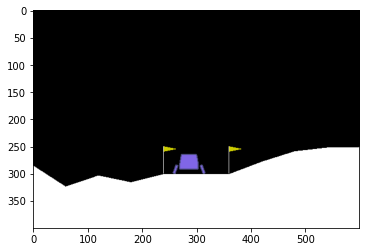

In [6]:
env = gym.make("LunarLander-v2")
seed = 18
set_seed(seed, env)


hyper_params = {
    "state_dim": env.observation_space.shape[0],
    "action_dim": env.action_space.n,
    'max_timesteps': 1000,
    'learn_freq': 5,
    'gamma': .99,
    'lr': .0015,
    'num_episodes': 1000, 
    'memory_size': int(1e6),
    'eps_start': 1.0,
    'eps_end': 0.01,
    'decay_rate': 0.985, 
    'decay_type': 'power',
    'weights_file': "/content/solved/DQN_20210317_0306_best.pth",
    'render': True,
    'batch_size': 64,
    'mid_dim': 64
}

solved_dir = './solved/'
if not os.path.exists(solved_dir):
    os.mkdir(solved_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
agent = DQNAgent(hyper_params["state_dim"],
                    hyper_params["action_dim"],
                    hyper_params['lr'],
                    hyper_params['gamma'],
                    hyper_params['memory_size'],
                    hyper_params['batch_size'],
                    hyper_params['eps_start'],
                    hyper_params['eps_end'],
                    hyper_params['decay_rate'],
                    device,
                    hyper_params['mid_dim'],
                    decay_type=hyper_params['decay_type'],
                    learn_freq=hyper_params['learn_freq'])
# 
simulate_save(agent, env, device)

### **Question 2 (5pts)** Describe your Neural Network (number of hidden layers, hyparameters etc). 

*Answer:* The model structure have three fully connected layers, each layer are connect by rectifiers layer. The input and output and middle layer dimension are 64.

After 500 max episode training, the network are getting stabled and the mean (100 episode) reward reach to 200 at 330 episode. 

The hyparameters list below:
```
hyper_params = {
    "state_dim": env.observation_space.shape[0],
    "action_dim": env.action_space.n,
    'max_timesteps': 1000, # timesteps in each episode
    'learn_freq': 3, # delay update 
    'gamma': .99,
    'lr': .001, # learning rate
    'num_episodes': 500, 
    'memory_size': int(1e6), # replay memory size
    'eps_start': 1.0, # start eplison
    'eps_end': 0.01, # min eplison
    'decay_rate': 0.985, 
    'decay_type': 'power', # decay_rate*eplison
    'weights_file': "" # used to testing and get video
    'render': True,
    'batch_size': 64,
    'mid_dim': 64
}
```
The image below shows the reward of each episode, the deep blue line is moving average for 100 episode, the sallow blue is the regular one.

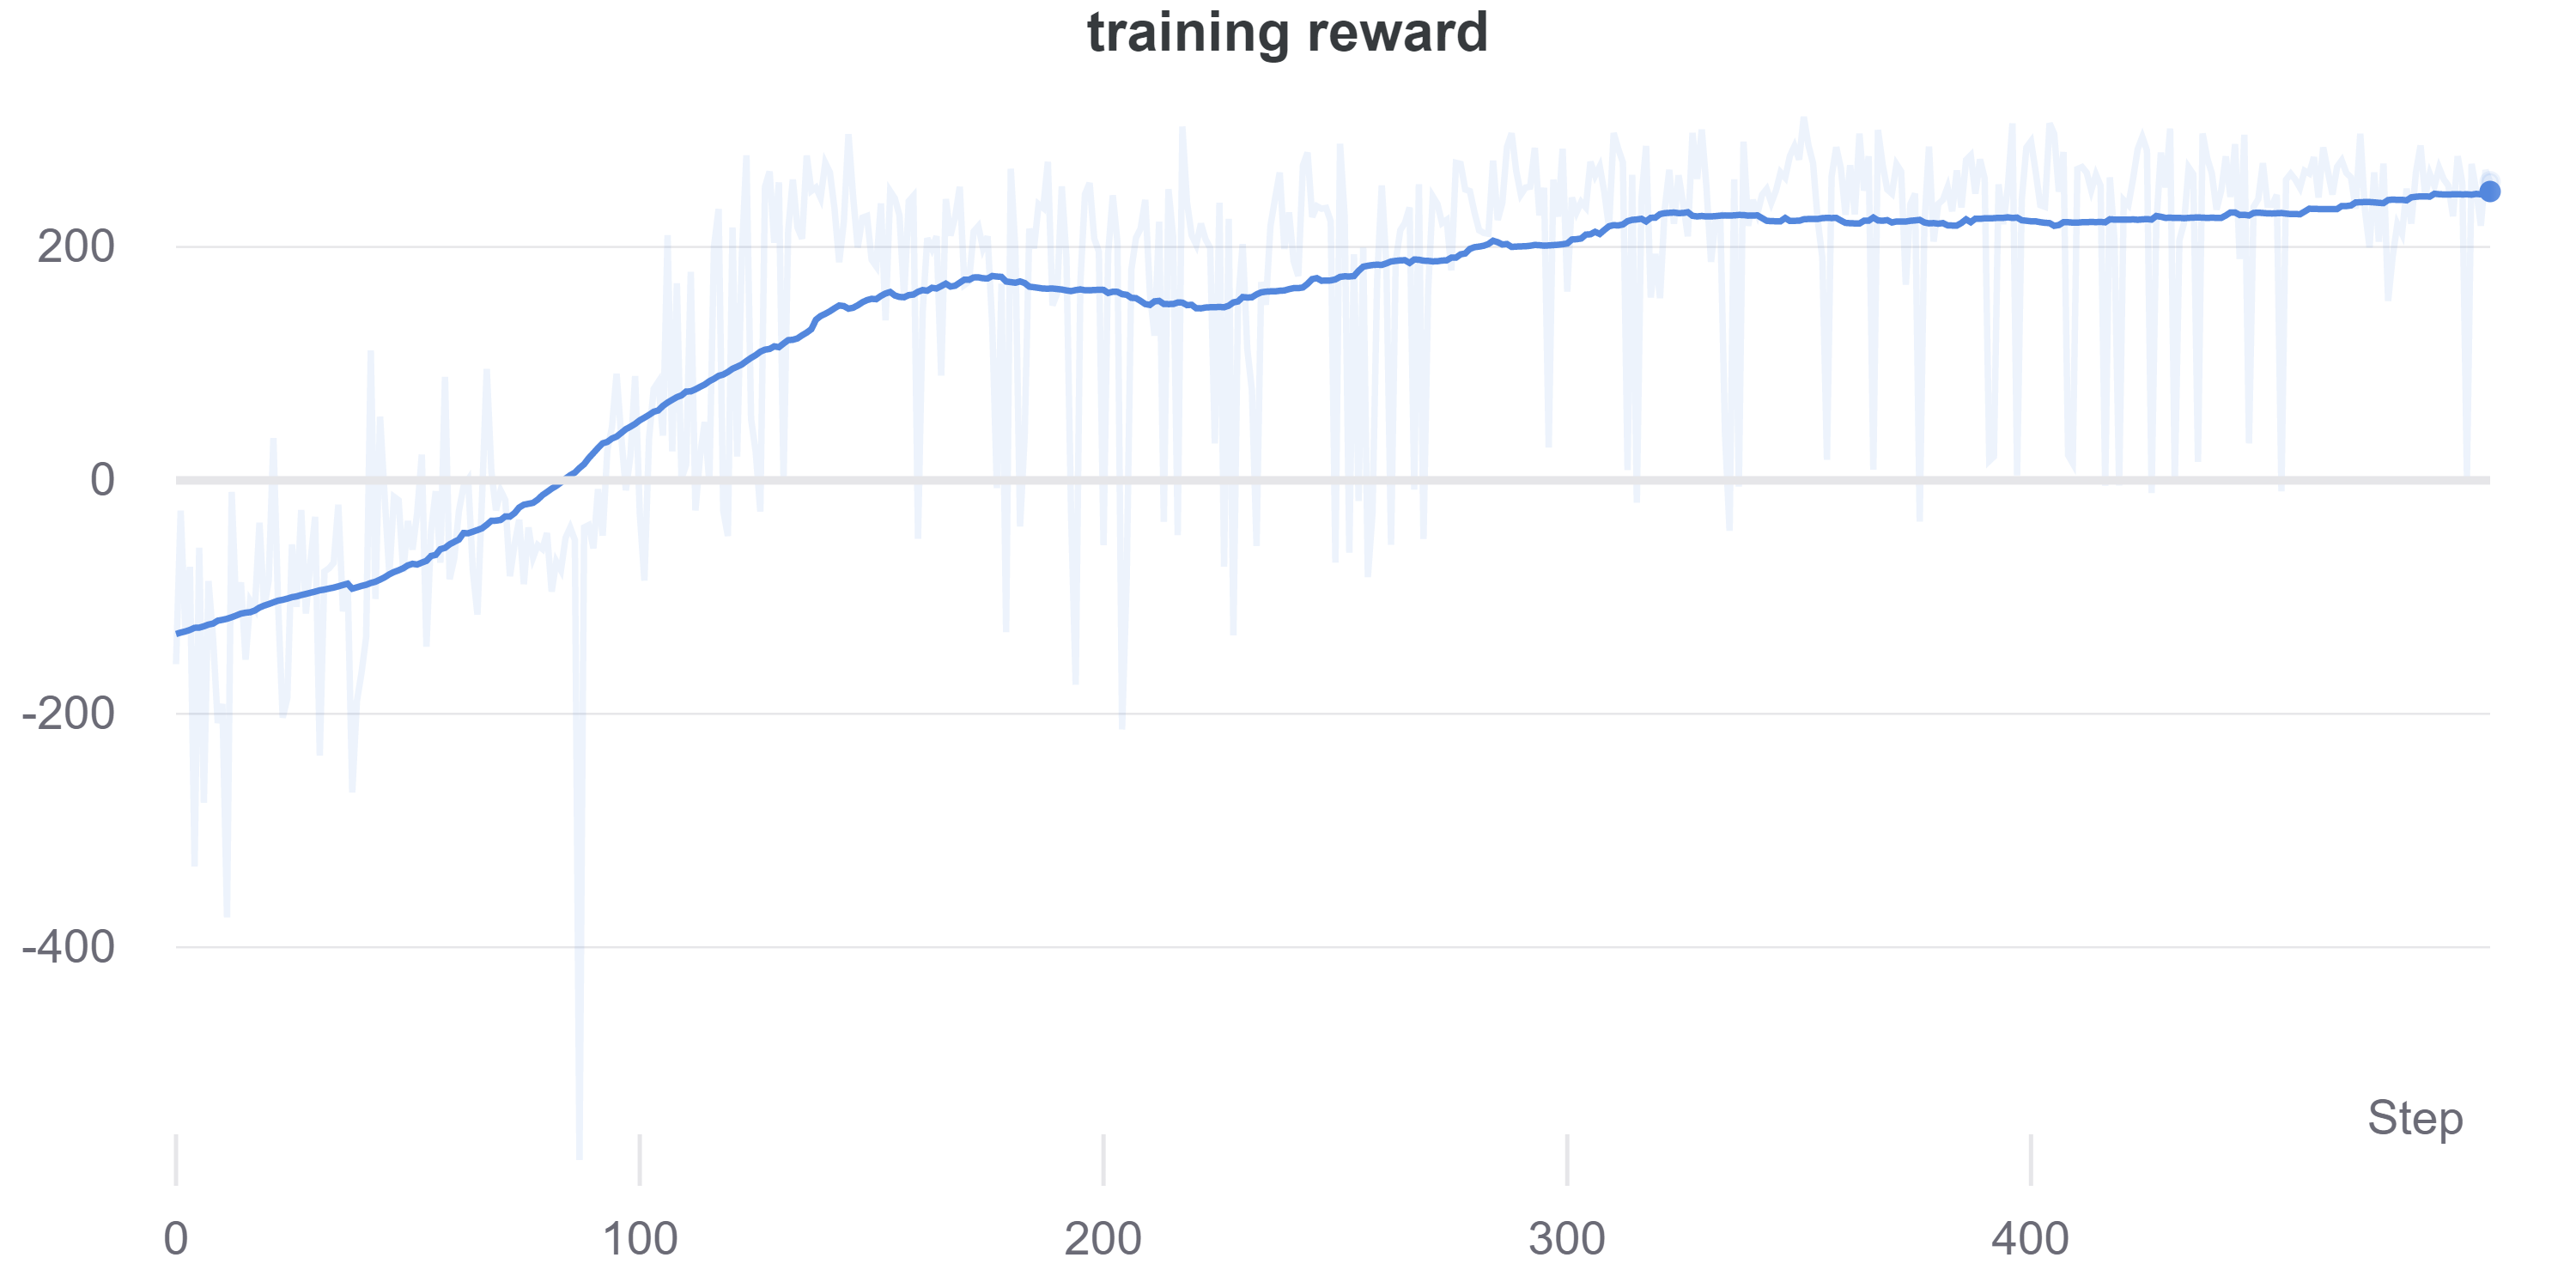

In [ ]:
from IPython.display import Image

Image(filename =r'/content/memory')

### **Question 3 (10pts)** You have to convince the world that you have landed on the moon (There are some who will not believe you), Link a video of your trained agent in the code block below. 

In [ ]:
show_video("/content/test.mp4")

### **Question 4 (10 pts)** Implement DQN (using a Neural Network as the Q function approximator) without experience replay. Plot the reward per episode. Link your plot in the code block below and briefly describe your observation.  

In [ ]:
wandb.init(project='ecen689-lunarlander', entity='dyllanwli')
# for plot

In [ ]:
# without memory
env = gym.make("LunarLander-v2")
seed = 18
set_seed(seed, env)


hyper_params = {
    "state_dim": env.observation_space.shape[0],
    "action_dim": env.action_space.n,
    'max_timesteps': 1000,
    'learn_freq': 1,
    'gamma': .99,
    'lr': .001,
    'num_episodes': 800, 
    'memory_size': int(1),
    'eps_start': 1.0,
    'eps_end': 0.01,
    'decay_rate': 0.999, 
    'decay_type': 'power',
    'weights_file': "/content/solved/DQN_20210317_0306_best.pth",
    'render': True,
    'batch_size': 64,
    'mid_dim': 64
}

wandb.config.update(hyper_params)

solved_dir = './solved/'
if not os.path.exists(solved_dir):
    os.mkdir(solved_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
agent = DQNAgent(hyper_params["state_dim"],
                    hyper_params["action_dim"],
                    hyper_params['lr'],
                    hyper_params['gamma'],
                    hyper_params['memory_size'],
                    hyper_params['batch_size'],
                    hyper_params['eps_start'],
                    hyper_params['eps_end'],
                    hyper_params['decay_rate'],
                    device,
                    hyper_params['mid_dim'],
                    decay_type=hyper_params['decay_type'],
                    learn_freq=hyper_params['learn_freq'])
# 
wandb.watch(agent.model)

print("start training")
paths = {'solved_dir': solved_dir}
agent.train(env, paths, num_episodes=hyper_params['num_episodes'],
            max_t=hyper_params['max_timesteps'], 
            use_memory=False)
# the implementation here is 
# def learn_without_memory(self, state, action, reward, next_state, done):

#     state      = torch.FloatTensor([state]).to(self.device)
#     next_state = torch.FloatTensor([next_state]).unsqueeze(0).to(self.device)
#     action     = torch.LongTensor([action]).to(self.device)
#     reward     = torch.FloatTensor([reward]).to(self.device)
#     done       = torch.FloatTensor([done]).to(self.device)

#     curr_q_vals = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)
#     next_q_vals = self.model(next_state).max(1, keepdim=True)[0].detach()

#     target = (reward + self.gamma * next_q_vals * (1 - done)).to(self.device)
#     # expected q value
#     loss = F.smooth_l1_loss(curr_q_vals, target)
#     self.optimizer.zero_grad()
#     loss.backward()
#     self.optimizer.step()
#     return loss.item()

using cuda
start training


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:270: UserWarning: Using a target size (torch.Size([1, 1, 4])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


```
A simple illustration of not using memory is:
Initialize the DQN
For N episodes
    state = env.reset()
    Loop until done:
        action = choose_action by DQN
        next_state, reward, done, ... = after env action
        get predict q value and next q value by DQN
        bootstrapped q value
        get smooth_l1_loss of predict q and boostrapped q
        apply adam gradient descent improve
```
Without using experience memory, the network seems hard to converge, and the reward keeps negetative even though I have done many hyper parameter tuning.

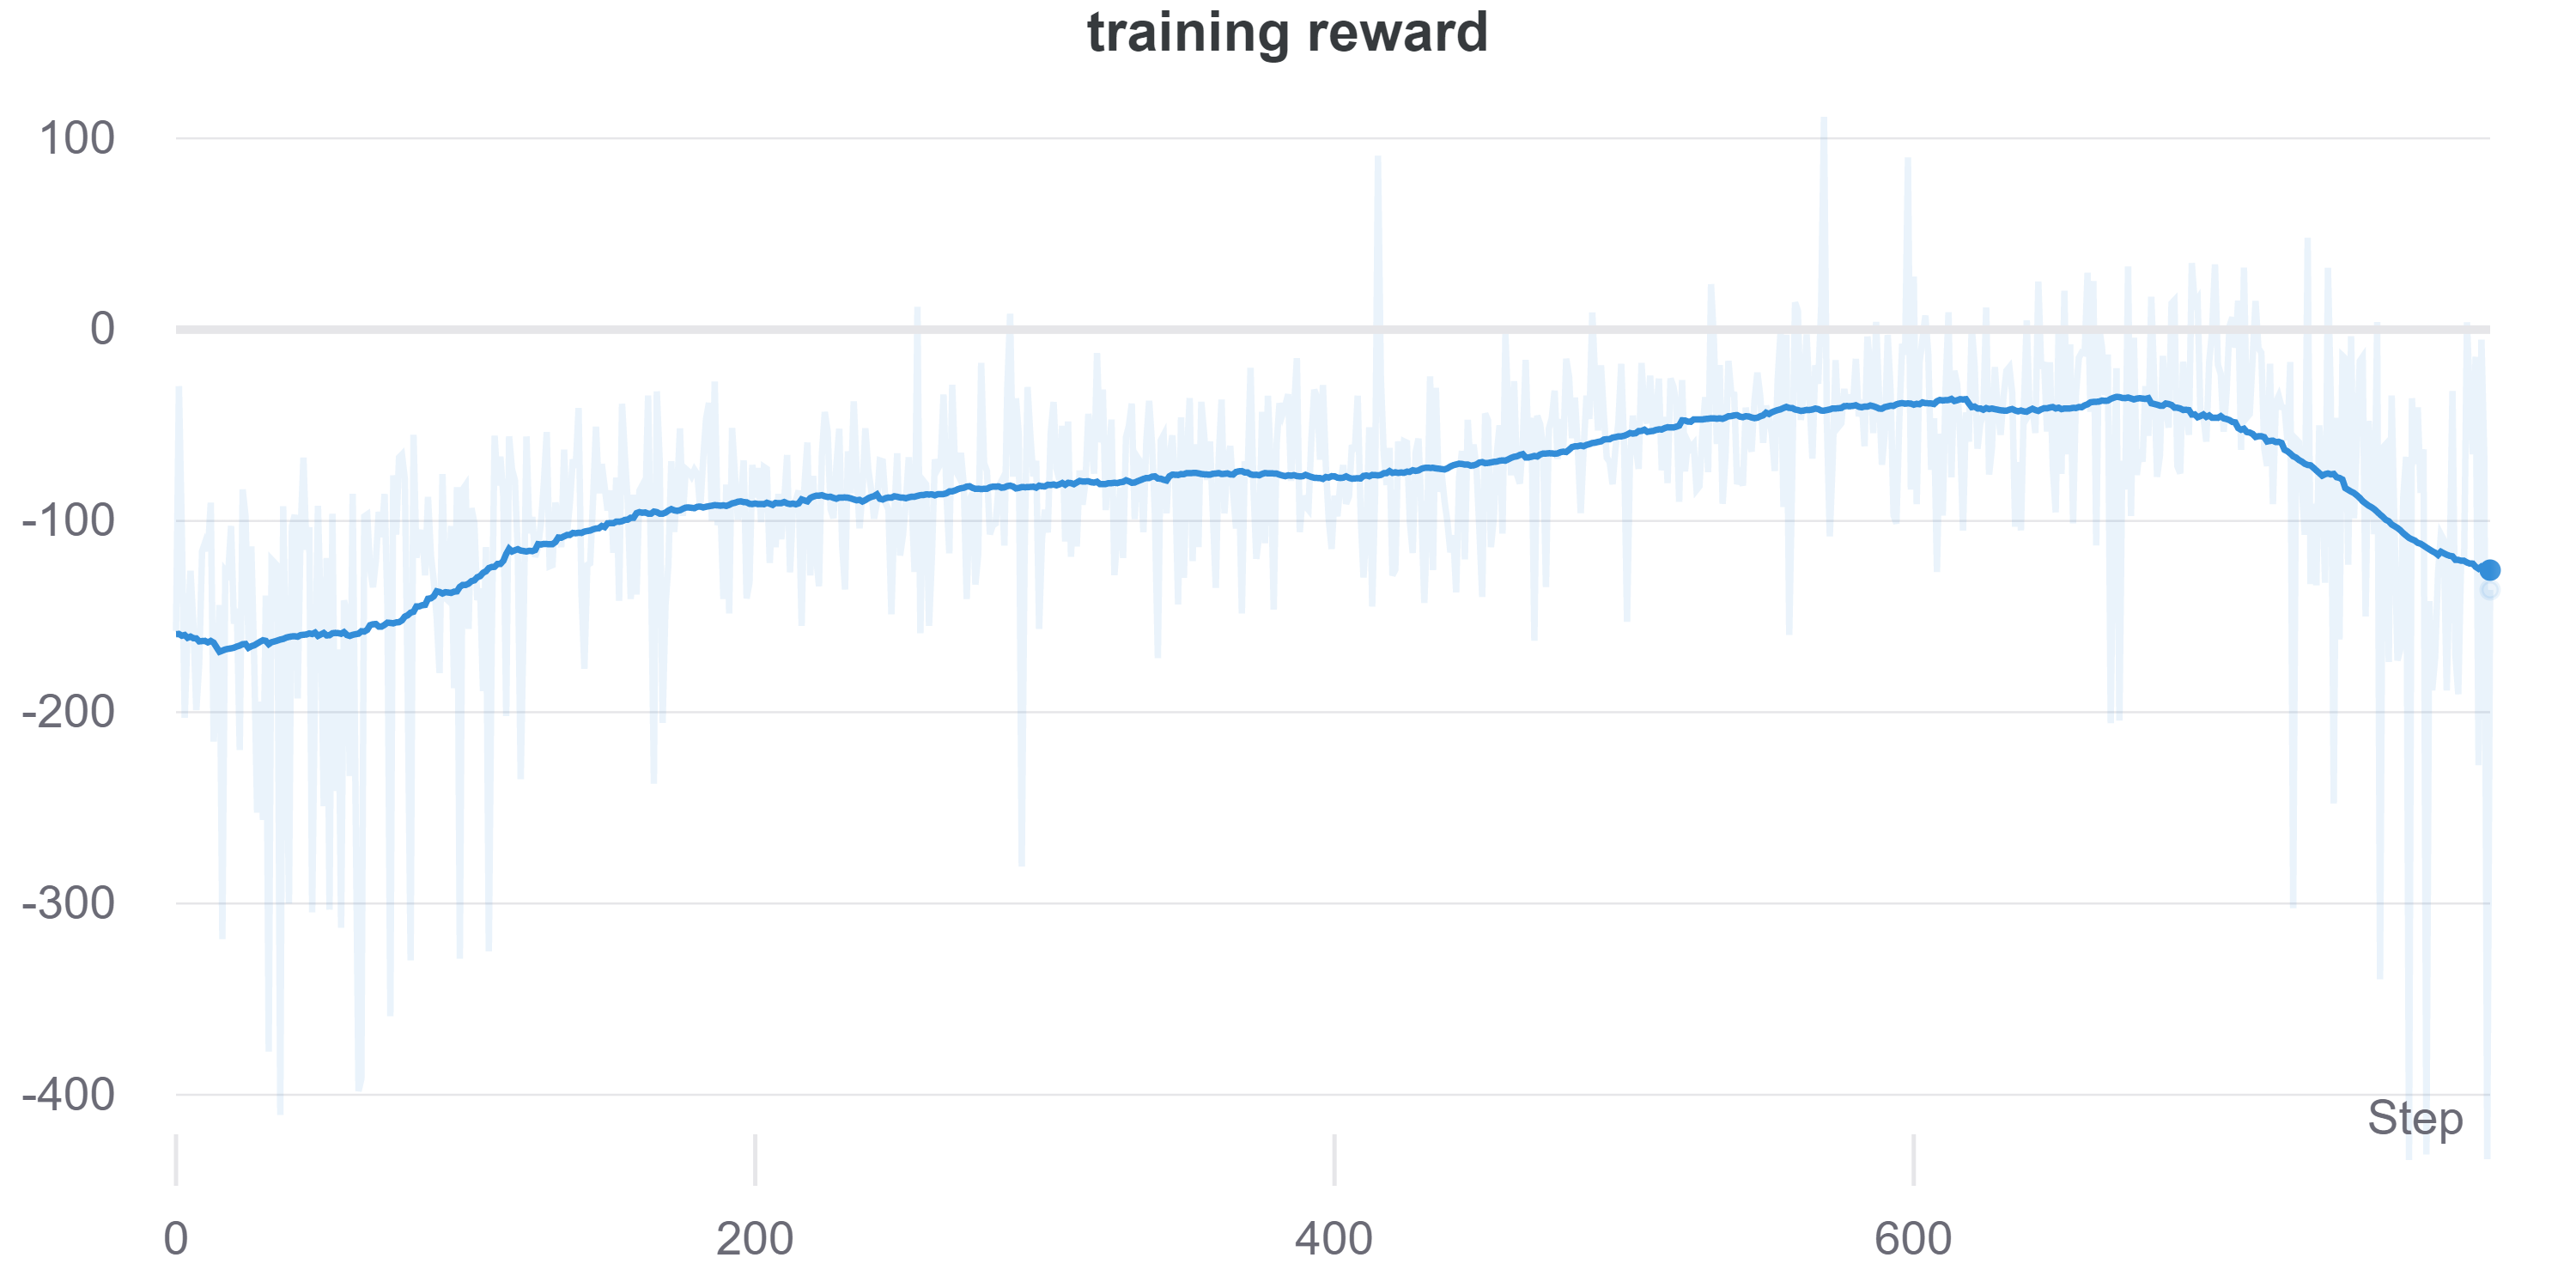

In [ ]:
Image(filename =r'/content/nomemory.png')

### **Question 5 (5pts)** How would you train your agent if the action space is continuous?
 
*Answer:* In continuous environment, action is two real values vector from -1 to +1. The negative and postiive controls the orientations. The abs() of action controls the power. To train dqn agent when action space is continuous, we can let the policy network ouput float vector (closed bound), it can be considered as continuous action, we need to normalization process and considerate minimize value. Then the action could be:
```
a_continuous_i = a_continuous_i - min(a_continuous_i) + \eplison
a_continuous_i = a_continuous_i / sum{1~i}(a_continuous_i)
a = rd.choice(a_continuous_i)
```

### **Question 6 (Bonus Question) (20pts)** Implement DQN using a Linear Classifier (or Regressor) as the Q function approximator  (*Hint: You might have to use kernels*)
* Describe your function approximator
* Plot the reward per episode 
* Link your video
* Include your code with your submission 

In [ ]:
!jupyter nbconvert --to html Report.ipynb

[NbConvertApp] Converting notebook Report.ipynb to html
[NbConvertApp] Writing 1323213 bytes to Report.html
